<font size = 12> Calibration Notebook </font>


Author: Leonardo Assis Morais

Calibrate the TES detector using area measurements. 

The output of this notebook is a .csv file with the counting thresholds <br>
required to convert TES area information to photon-number information. 

Use the notebook Counting Photons.ipynb to obtain photon-number <br>
information from your raw TES area data.

Summary: 
1) Getting data
2) Importing data
3) Calibration
4) Sanity Check
5) Additional Feature: plotting other characteristics

# Getting the calibration data

You will need to have the calibration data on your computer <br>
for this notebook to work properly. 

In order to get the data, you will need to use a ftp protocol.

In Mac, I can press CMD + K and type the following address:<br> ftp://smp-qtlab11.instrument.net.uq.edu.au

This wiil grant you access to the folder ’captures’ where all <br>
measurements made with the FPGA are stored. Copy the folder with <br>
your data set to your machine in a folder that you know. <br>
You will need to know this address to run the notebook below.

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import tes

In [39]:
# for development/debugging of the tes package
#%load_ext autoreload
%reload_ext autoreload

# Importing data

In [43]:
from tes.data import CaptureData

# edit the path here with the folder where your data is located
datapath = ('/Users/leo/TES_package_and_data/TES3_80mK_820nm_10khz_'
            '50ns_2_6V_1MBW_peak1_h078df2b2/drive-pulse_BL-pulse_'
            'threshold-slope_max')

# function to get the data from files
data = CaptureData(datapath)
# boolean mask for events in channel 0 - the photon detections
ch0 = data.mask(0)
# boolean mask for events in channel 1 -  the laser drive pulses.
ch1 = data.mask(1)
# this is the relative time since the last event
times = data.time  
heights = data.rise[ch0]['height'][:,0]
areas = data.area[ch0]
minima = data.rise[ch0]['minimum'][:,0]
lengths = data.pulse_length[ch0]
rise_time = data.rise[ch0]['rise_time'][:,0]

# Calibration

Using the cell below to find the position of the peaks of the histogram. 

The data and model will be plotted so the user can make a sanity check of this fit first guess.

The number of events in the analysed data is: 14884856
The number of peaks found in this data set was 10.


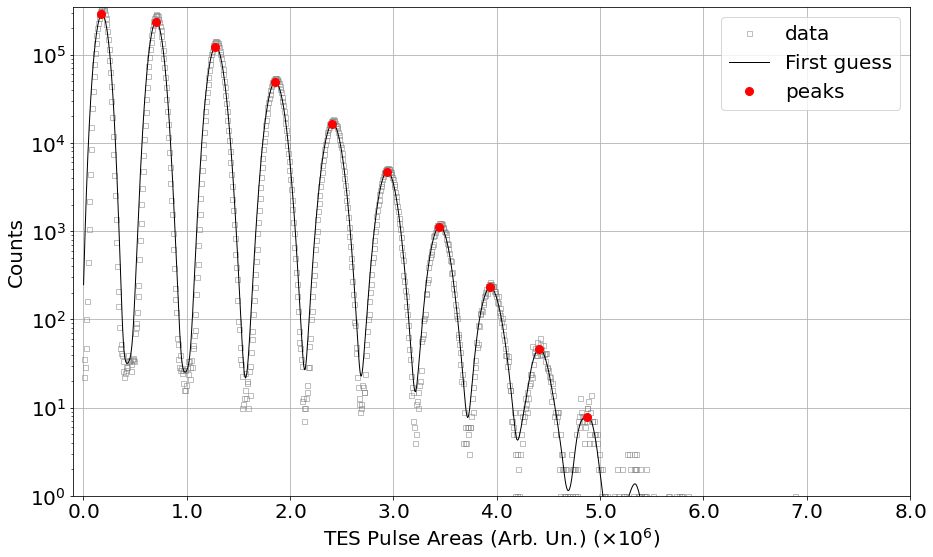

In [45]:
%matplotlib inline
from tes.calibration import guess_histogram, plot_guess

# histogram parameters
BIN_NUMBER = 1000
WIN_LENGTH = 25
MINIMUM = 7
MAX_AREA = 1e7

# figure parameters
FIG_WIDTH = 15
FIG_HEIGHT = 9
YLIM = [1e0, 3.5e5] # limits for y axis

# calculating educated fitting
counts, smooth_hist, bin_centre, max_i, max_list = guess_histogram(areas,
                                                         BIN_NUMBER,
                                                         WIN_LENGTH,
                                                         MINIMUM,
                                                         MAX_AREA)

# plotting educated fitting with maxima points
fig, ax = plt.subplots(figsize=[FIG_WIDTH,FIG_HEIGHT])
plot_guess(ax, counts, smooth_hist, bin_centre, max_i)
print("The number of peaks found in this data set was {}.".format(len(max_i)))
# plotting details
ax.set_ylim(YLIM)
ax.set_xlim(-0.1e6,np.max(ax.get_xticks()))
ax.grid('on')

## Fitting the data with a mixture model of gaussian distributions

Used lmfit package for fitting. Documentation, tutorials, and further informations here: 
https://lmfit.github.io/lmfit-py/

The model is composed of a sum of 16 Gaussian distributions:

\begin{equation}
    M(A_1, \mu_1, \sigma_1, ..., A_{16}, \mu_{16}, \sigma_{16}) = \sum_{n=1}^{16} G_n(a),
\end{equation}

where

\begin{equation}
    G_n(a) = \frac{A_n}{\sqrt{2\pi} \sigma_n} \exp \bigg( \frac{-(a - \mu_n)^2}{2 \sigma_n^2}\bigg),
\end{equation}

$a$ is the area, $\sigma_n^2$ is the gaussian variance, $A_n$ is the amplitude, $\mu_n$ is the mean.

## Creating the histogram

In [46]:
from tes.calibration import area_histogram

MAX_AREA = 1e7
BIN_NUMBER = 45000

bin_centre, counts, error, bin_width = area_histogram(MAX_AREA, BIN_NUMBER, areas)

The number of points in the analysed data is: 14884856 .
We analyse data up to: 10000000.0 area units.
The number of bins in the analysed data is: 45000 .
The size of each bin is: 222.22222222222223 .


## Fitting 

In [47]:
from tes.calibration import residual_gauss
import lmfit

# requires max_list from guess_histogram
MAX_IDX = len(max_i) # number of distributions to be used+1
INIT_SCALE = 40889 
INIT_AMP = 75751

params = lmfit.Parameters()

[params.add(r'scale{}'.format(idx), value=INIT_SCALE) 
 for idx in range(1, MAX_IDX)]
[params.add(r'loc{}'.format(idx), value=max_list[idx]) 
 for idx in range(1,MAX_IDX)]
[params.add(r'amp{}'.format(idx), value=INIT_AMP) 
 for idx in range(1,MAX_IDX)] 

gauss_fit = lmfit.minimize(residual_gauss, params, args=(bin_centre, counts, error,MAX_IDX))

In [7]:
# uncomment to see fit report
# print(lmfit.fit_report(gauss_fit))

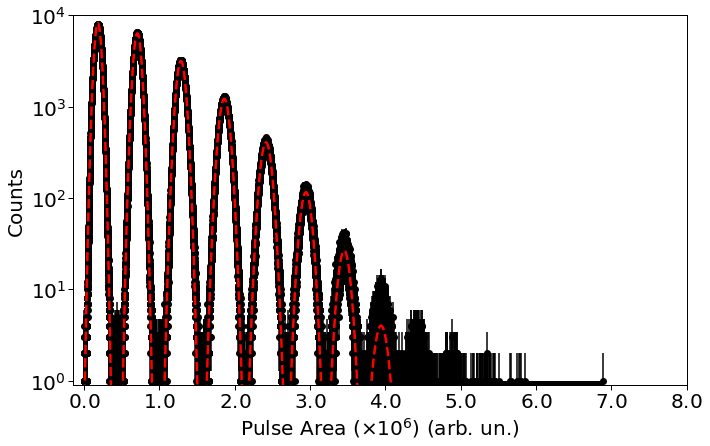

In [48]:
# requires area_histogram
from tes.calibration import plot_area, gaussian_model
%matplotlib inline

# creating the model
model_gauss = gaussian_model(gauss_fit, counts, bin_centre, MAX_IDX)

# plotting the figure
width = 11
golden_ratio = (np.sqrt(5.0)-1.0)/2.0

fig, ax = plt.subplots(figsize=[width, width*golden_ratio])

# edit plot steps to avoid plotting all bins
plot_steps = 1
plot_area(ax, bin_centre, counts, error, model_gauss, plot_steps)

# uncomment to save fit/edit figure path
# fig.savefig('./Chapter3/Figures/area_histogram_16.pdf', bbox_inches='tight',
#             dpi=300)

Given the area histogram above, the function below will find the <br>
position of the counting thresholds by positioning them at <br>
the intersection point of two adjacent normalised distributions. <br>

In [49]:
from tes.calibration import find_thresholds

# requires: gauss_fit, max_i
# returns: dist, thresholds
# objective: from fitting obtained in last section, obtain normalised distributions 
#            for plots and position of counting thresholds

# normally you won't need to change the variable below.
# see help(find_thresholds) for more info.
const = 3e4
dist, thresholds = find_thresholds(gauss_fit, max_i, bin_centre, counts, const)

# Saving counting thresholds

Save all counting thresholds in a .csv file to be used for converting area information into photon-number information.

In [50]:
import csv

folder_name = '/Users/leo/Desktop/'
file_name = 'calibration'
with open(folder_name+file_name+'.csv', mode='w') as count_file: 
    fock_numbers = [i for i in range(0, len(thresholds)+1)]
    writer = csv.writer(count_file)
    count_file.write(str(datapath) + "\n")
    writer.writerow(fock_numbers)
    writer.writerow(thresholds)

# Sanity Check: Plotting thresholds and normalised distributions

(-1e-08, 1.1e-05)

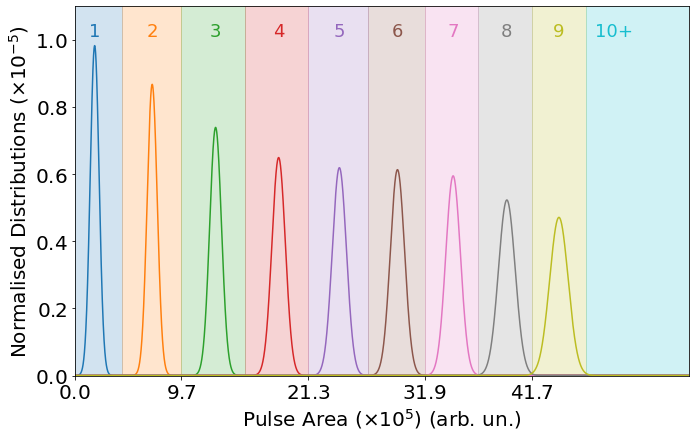

In [51]:
from tes.calibration import correct_xticks, plot_normalised
# Creating the figure

GOLDEN_RATIO = (np.sqrt(5.0)-1.0)/2.0
FIG_WIDTH = 11
FIG_HEIGHT = FIG_WIDTH*GOLDEN_RATIO
STEP_LABEL = 2 # every other threshold has tick label (x-axis)
LAST_THRESH = 5.6e6
YMIN = -0.001e-5
YMAX = 1.1e-5

fig, ax = plt.subplots(figsize=[FIG_WIDTH, FIG_HEIGHT])

plot_normalised(ax, max_i, bin_centre, dist, thresholds)
# fixing xtick labels
expx = correct_xticks(ax)
expx = expx-1
ax.set_xticks(thresholds[::STEP_LABEL])
tick_values = thresholds/10**expx
tick_labels = [r'${:2.1f}$'.format(tick) for tick in tick_values]
ax.set_xticklabels(tick_labels[::STEP_LABEL]);
ax.set_xlabel(r'Pulse Area $(\times 10^{{ {} }})$ (arb. un.)'.format(expx))
ax.set_xlim(0, LAST_THRESH)
ax.set_ylim(YMIN, YMAX)

# Other components

If you want to see the data for different components, <br>
you can use the code below.

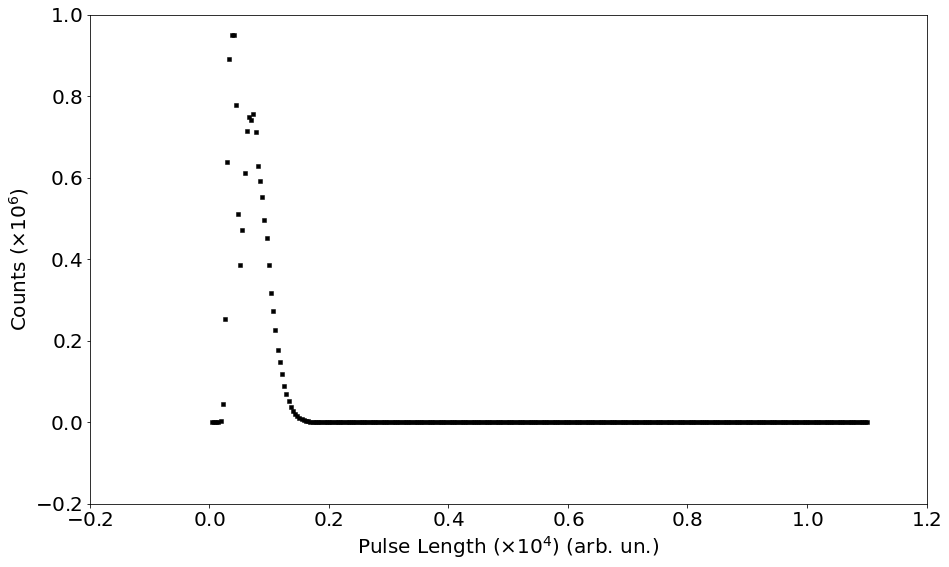

In [53]:
%matplotlib inline
from tes.calibration import plot_histogram

# histogram parameters
BIN_NUMBER = 300
measurement = 'Length'

# figure parameters
FIG_WIDTH = 15
FIG_HEIGHT = 9

# plotting educated fitting with maxima points
fig, ax = plt.subplots(figsize=[FIG_WIDTH,FIG_HEIGHT])
plot_histogram(ax, lengths, BIN_NUMBER, measurement)

<font size = 12>END OF NOTEBOOK </font>